In [2]:
import os
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report

In [3]:
# Constants
IMAGE_SIZE = (150, 150)
DATASET_PATH = "plant_dataset_main"
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
VALID_PATH = os.path.join(DATASET_PATH, "valid")
PICKLE_TRAIN = "train_data.pkl"
PICKLE_VALID = "valid_data.pkl"
SAMPLES_TRAIN_HEALTHY = 520     # 12 x 520 = 6000
SAMPLES_TRAIN_DISEASED = 260    # 26 x 250 = 6760
SAMPLES_VALID_HEALTHY = 130     # 12 x 130 = 1560
SAMPLES_VALID_DISEASED = 65     # 26 × 65 = 1690

In [3]:
# Function to load images
def load_images_from_folders(base_folder, samples_healthy, samples_diseased):
    X, y = [], []
    for label, (category, samples_per_class) in enumerate([
        ("healthy", samples_healthy), ("diseased", samples_diseased)
    ]):
        folder_path = os.path.join(base_folder, category)
        subfolders = os.listdir(folder_path)
        for subfolder in subfolders:
            subfolder_path = os.path.join(folder_path, subfolder)
            images = os.listdir(subfolder_path)[:samples_per_class]
            for img_name in images:
                img_path = os.path.join(subfolder_path, img_name)
                img = load_img(img_path, target_size=IMAGE_SIZE)
                img_array = img_to_array(img) / 255.0
                X.append(img_array)
                y.append(label)
    return np.array(X), np.array(y)

In [4]:
# Load dataset
X_train, y_train = load_images_from_folders(TRAIN_PATH, SAMPLES_TRAIN_HEALTHY, SAMPLES_TRAIN_DISEASED)
X_valid, y_valid = load_images_from_folders(VALID_PATH, SAMPLES_VALID_HEALTHY, SAMPLES_VALID_DISEASED)

In [5]:
# Pickle dataset
for data, labels, pickle_file in [(X_train, y_train, PICKLE_TRAIN), (X_valid, y_valid, PICKLE_VALID)]:
    with open(pickle_file, "wb") as f:
        pickle.dump((data, labels), f)
    print(f"Saved {pickle_file} with {data.shape[0]} samples")

Saved train_data.pkl with 13000 samples
Saved valid_data.pkl with 3250 samples


In [4]:
# Load pickled data
with open(PICKLE_TRAIN, "rb") as f:
    X_train, y_train = pickle.load(f)
with open(PICKLE_VALID, "rb") as f:
    X_valid, y_valid = pickle.load(f)

In [4]:
# Count samples in each category
train_healthy_count = np.sum(y_train == 0)
train_diseased_count = np.sum(y_train == 1)
valid_healthy_count = np.sum(y_valid == 0)
valid_diseased_count = np.sum(y_valid == 1)

In [5]:
print(f"Train Set: Healthy = {train_healthy_count}, Diseased = {train_diseased_count}")
print(f"Validation Set: Healthy = {valid_healthy_count}, Diseased = {valid_diseased_count}")

Train Set: Healthy = 6240, Diseased = 6760
Validation Set: Healthy = 1560, Diseased = 1690


In [6]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weight_dict)

Class Weights: {0: np.float64(1.0416666666666667), 1: np.float64(0.9615384615384616)}


In [7]:
# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
model.summary()

c:\Users\Dell\anaconda3\envs\plant_disease\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,813,889 (25.99 MB)

 Trainable params: 6,812,929 (25.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation for Training Data
train_datagen = ImageDataGenerator(
    rotation_range=30,      # Rotate images up to 30 degrees
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2, # Random vertical shifts
    shear_range=0.2,        # Shear transformation
    zoom_range=0.2,         # Zoom-in/out
    horizontal_flip=True,   # Flip images horizontally
    fill_mode='nearest'     # Fill in missing pixels
)

# No augmentation for validation (only rescale)
valid_datagen = ImageDataGenerator()

# Apply Data Augmentation to Training Data
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=32,
    shuffle=True
)

# Apply Rescaling to Validation Data
valid_generator = valid_datagen.flow(
    X_valid, y_valid,
    batch_size=32,
    shuffle=False
)

# Verifying the shapes
print(f"Training Data: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation Data: {X_valid.shape}, Labels: {y_valid.shape}")

Training Data: (13000, 150, 150, 3), Labels: (13000,)
Validation Data: (3250, 150, 150, 3), Labels: (3250,)


In [ ]:
# Train model
history = model.fit(X_train, y_train, 
                    epochs=10, 
                    batch_size=32, 
                    validation_data=(X_valid, y_valid),
                    class_weight=class_weight_dict) 

In [12]:
import json

# Save history as a JSON file
with open("binary_training_history_3.json","w") as f:
    json.dump(history.history, f)

In [13]:
# Save the model
model.save("binary_detection_model_3.h5")

In [ ]:
# Evaluate model
y_pred = (model.predict(X_valid) > 0.5).astype("int32")
print(classification_report(y_valid, y_pred, target_names=["Healthy", "Diseased"]))

102/102 ━━━━━━━━━━━━━━━━━━━━ 24s 219ms/step
              precision    recall  f1-score   support

     Healthy       0.96      0.95      0.96      1560
    Diseased       0.96      0.97      0.96      1690

    accuracy                           0.96      3250
   macro avg       0.96      0.96      0.96      3250
weighted avg       0.96      0.96      0.96      3250



61/61 ━━━━━━━━━━━━━━━━━━━━ 42s 691ms/step


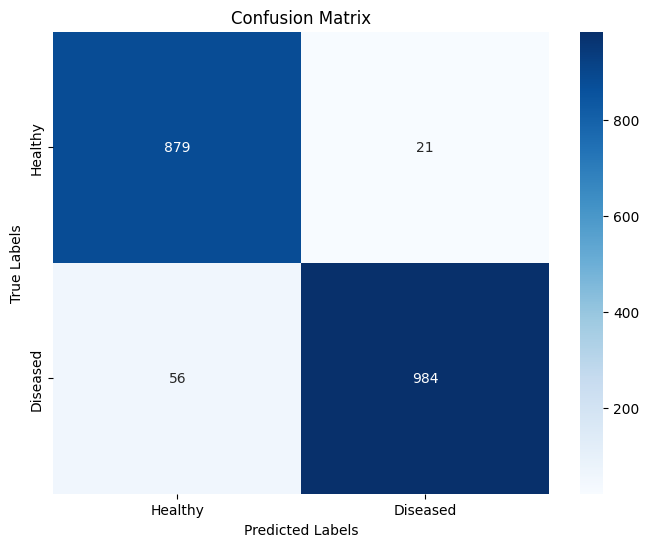

              precision    recall  f1-score   support

     Healthy       0.94      0.98      0.96       900
    Diseased       0.98      0.95      0.96      1040

    accuracy                           0.96      1940
   macro avg       0.96      0.96      0.96      1940
weighted avg       0.96      0.96      0.96      1940



In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load Binary Classification Model
model = tf.keras.models.load_model("plant_disease_website\\models\\binary_model.h5")

# Predict labels using the model
y_pred = (model.predict(X_valid) > 0.4).astype("int32")

# Compute confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Diseased"], yticklabels=["Healthy", "Diseased"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(y_valid, y_pred, target_names=["Healthy", "Diseased"]))